# Анализ данных в индустрии

По данным проекта Тинькофф квест построить воронку, которая показывает в динамике по неделям и месяцам, сколько клиентов посещает сайт, и какая доля из них регистрируется на нем \ подает заявку на игру \ по факту приходит на нее. Количество клиентов и конверсии необходимо изобразить на одном графике.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Подключение-к-базе-данных" data-toc-modified-id="Подключение-к-базе-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подключение к базе данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Визуализация-конверсий" data-toc-modified-id="Визуализация-конверсий-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Визуализация конверсий</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Импорт библиотек

In [1]:
!pip3 install psycopg2-binary

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Подключение к базе данных

In [3]:
conn = psycopg2.connect(
 host="158.160.52.106",
 port=5432,
 database="postgres",
 user="student",
 password="JvLda93aA",
)

Строки с запросом к базе данных

Запрос объединяет 4 таблицы:
- client,
- account,
- application,
- game.
Из объединения берутся строки с уникальным значением идентификатора клиента, т.е. если клиент подал несколько заявок или сыграл в несколько игр, то берется только одна строка, в которой учитывается наличие заявок/игр.
Чтобы учесть  факт прихода на игру, делает сортировку по флагу *game_flg*, тогда если у клиента есть хотя бы одна игра, она учтется.

Затем группируем по неделям/месяцам и считаем суммы.

В результате получаем таблицу по неделям/месяцам с количеством клиентов, которые посетили сайт, зарегистрировались, подали заявку на игру и сыграли.

In [4]:
query_strings = ["with foo as \
                ( \
	                select distinct on (c.client_rk) c.client_rk as client_rk, \
		              ac.account_rk as account_rk, \
		              ap.application_rk as application_rk, \
		              date_trunc('week', c.visit_dttm) as visit_period, \
		              g.game_rk as game_rk, \
		              g.game_flg as flg \
	                from msu_analytics.client as c \
	                left join msu_analytics.account as ac using (client_rk) \
	                left join msu_analytics.application as ap using (account_rk) \
	                left join msu_analytics.game as g using (game_rk) \
	                order by c.client_rk, g.game_flg desc \
                ) \
                select foo.visit_period, \
	              count(foo.client_rk) as visit_cnt, \
	              count(foo.account_rk) as registered_cnt, \
	              count(foo.application_rk) as application_cnt, \
	              count(foo.game_rk) filter (where foo.flg = 1) as game_cnt \
              from foo \
              group by foo.visit_period \
              order by visit_period desc",
              "with foo as \
                ( \
	                select distinct on (c.client_rk) c.client_rk as client_rk, \
		              ac.account_rk as account_rk, \
		              ap.application_rk as application_rk, \
		              date_trunc('month', c.visit_dttm) as visit_period, \
		              g.game_rk as game_rk, \
		              g.game_flg as flg \
	                from msu_analytics.client as c \
	                left join msu_analytics.account as ac using (client_rk) \
	                left join msu_analytics.application as ap using (account_rk) \
	                left join msu_analytics.game as g using (game_rk) \
	                order by c.client_rk, g.game_flg desc \
                ) \
                select foo.visit_period, \
	              count(foo.client_rk) as visit_cnt, \
	              count(foo.account_rk) as registered_cnt, \
	              count(foo.application_rk) as application_cnt, \
	              count(foo.game_rk) filter (where foo.flg = 1) as game_cnt \
              from foo \
              group by foo.visit_period \
              order by visit_period desc"]

## Подготовка данных

In [5]:
# Функция считает конверсии из посетителей сайта в этапы воронки

def get_conversion(table):
  table['registered_conv'] = 100 * table.registered_cnt / table.visit_cnt
  table['application_conv'] = 100 * table.application_cnt / table.visit_cnt
  table['game_conv'] = 100 * table.game_cnt / table.visit_cnt

In [6]:
# Функция выбирает координаты x (период времени: неделя или месяц)
# и y (число клиентов и конверсии) из таблицы table

def get_coordinates(table):
  x  = table.visit_period.tolist()
  y0 = table.visit_cnt.tolist()
  y1 = table.registered_conv.tolist()
  y2 = table.application_conv.tolist()
  y3 = table.game_conv.tolist()
  y = np.vstack([y0, y1, y2, y3])
  return x, y

In [7]:
# Функция рисует график конверсии.
# Получает на вход координаты x и y, цвета mycolors, метки labs

def draw_conv(x, y, mycolors, labs):
  fig, ax1 = plt.subplots(figsize=(15,8))

  ax1.set_xlabel('Период времени')
  ax1.set_ylabel('Величина конверсии')
  ax1.plot(x, y[1], label=labs[1], color=mycolors[1], alpha=0.5)
  ax1.plot(x, y[2], label=labs[2], color=mycolors[2], alpha=0.5)
  ax1.plot(x, y[3], label=labs[3], color=mycolors[3], alpha=0.5)

  ax2 = ax1.twinx()
  ax2.set_ylabel('Количество посетителей', color=mycolors[0])
  ax2.plot(x, y[0], label=labs[0], color=mycolors[0])    
    
  h1, l1 = ax2.get_legend_handles_labels()
  h2, l2 = ax1.get_legend_handles_labels()
  ax1.legend(h1+h2, l1+l2, loc='center')
  ax1.grid(True)

In [8]:
class color:
   bold = '\033[1m'
   underline = '\033[4m'
   end = '\033[0m'

## Визуализация конверсий

Динамика по неделям

База данных - число клиентов


,visit_period,visit_cnt,registered_cnt,application_cnt,game_cnt
0,2023-01-30,81,22,5,0
1,2023-01-23,182,41,13,5
2,2023-01-16,181,43,13,4
3,2023-01-09,205,47,14,6
4,2023-01-02,201,58,16,4



--------------------------------------------------------------


База данных - конверсии из посетителей в этапы воронки


,visit_period,registered_conv,application_conv,game_conv
0,2023-01-30,27.160494,6.172840,0.000000
1,2023-01-23,22.527473,7.142857,2.747253
2,2023-01-16,23.756906,7.182320,2.209945
3,2023-01-09,22.926829,6.829268,2.926829
4,2023-01-02,28.855721,7.960199,1.990050



--------------------------------------------------------------




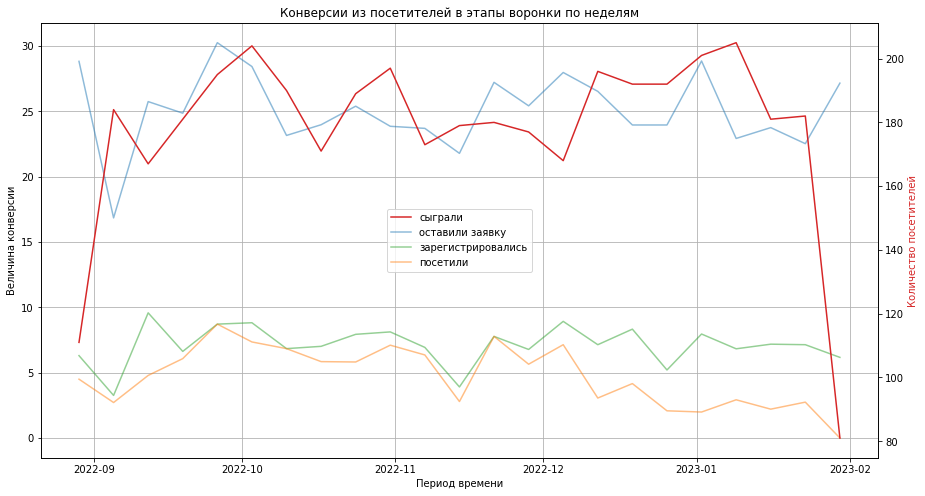


--------------------------------------------------------------

--------------------------------------------------------------


Динамика по месяцам

База данных - число клиентов


,visit_period,visit_cnt,registered_cnt,application_cnt,game_cnt
0,2023-02-01,32,8,0,0
1,2023-01-01,852,213,64,20
2,2022-12-01,805,196,57,33
3,2022-11-01,786,200,56,50
4,2022-10-01,843,217,65,56



--------------------------------------------------------------


База данных - конверсии из посетителей в этапы воронки


,visit_period,registered_conv,application_conv,game_conv
0,2023-02-01,25.000000,0.000000,0.000000
1,2023-01-01,25.000000,7.511737,2.347418
2,2022-12-01,24.347826,7.080745,4.099379
3,2022-11-01,25.445293,7.124682,6.361323
4,2022-10-01,25.741400,7.710558,6.642942



--------------------------------------------------------------




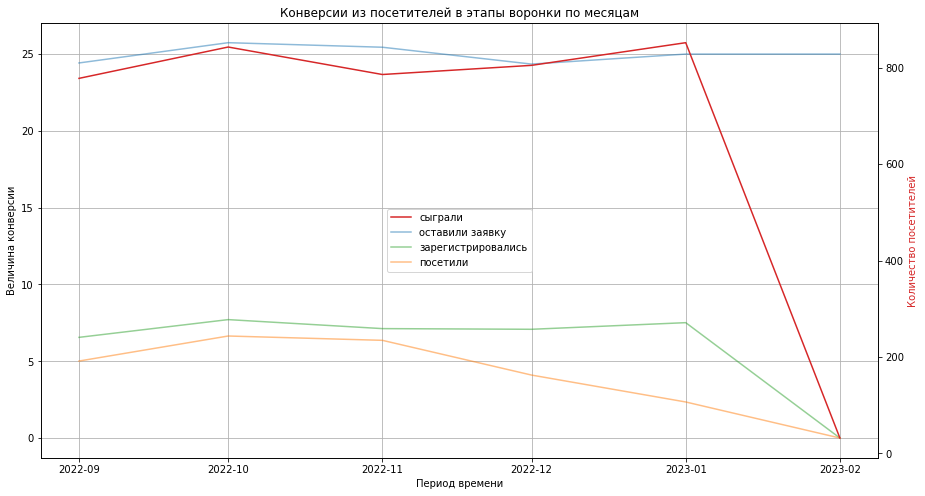


--------------------------------------------------------------

--------------------------------------------------------------




In [9]:
for i in range(len(query_strings)):
  if i == 0:
    period_string = 'по неделям'
  else:
    period_string = 'по месяцам'

  print(color.bold + color.underline + 'Динамика ' + period_string + \
        '\n' + color.end)
  # Получаем данные в датафрейм
  table = pd.read_sql(query_strings[i], conn)
  print('База данных - число клиентов')
  display(table.head())
  print('\n--------------------------------------------------------------\n\n')

  # Считаем конверсию
  get_conversion(table)
  print('База данных - конверсии из посетителей в этапы воронки')
  display(table[['visit_period', 'registered_conv', 'application_conv',\
                 'game_conv']].head())
  print('\n--------------------------------------------------------------\n\n')

  # Рисуем график
  labs = ['сыграли', 'оставили заявку', 'зарегистрировались', 'посетили']
  mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']
  x, y = get_coordinates(table)
  draw_conv(x, y, mycolors, labs)
  plt.title('Конверсии из посетителей в этапы воронки ' + period_string)
  plt.show();
  print('\n--------------------------------------------------------------')
  print('\n--------------------------------------------------------------\n\n')

## Выводы

По графику конверсий из посетителей в этапы воронки **по месяцам** мы видим, что с сентября 2022 года по январь 2023 уровень конверсий и числа посетителей сайта оставался приблизительно на одном уровне. С ноября 2022 года видно снижение доли клиентов, которые посетили игру. Но при этом уровень зарегистрировавшихся на игру оставался неизменным. Возможно, клиенты еще просто не успели посетить игру. Кроме того, видно снижение всех показателей с января 2023 года. Это также объясняется тем, что с момента 01.2023 прошло относительно немного времени, пользователи еще не успели зарегистрироваться/подать заявку на игру/сыграть.

По графику динамики конверсии **по неделям** можно заметить, что в середине месяца обычно число клиентов и все показатели ниже. Можно порекомендовать добавить рекламу или специальные предложения в середине месяца.